In [23]:
import pandas as pd

df_gas = pd.read_csv('Nat_Gas.csv')

df_gas['Dates'] = pd.to_datetime(df_gas['Dates'], format='%m/%d/%y')

df_gas = df_gas.set_index('Dates')

print("First few rows of the DataFrame:")
print(df_gas.head())

print("\nMissing values in the DataFrame:")
print(df_gas.isnull().sum())

print("\nDataFrame Information:")
df_gas.info()

First few rows of the DataFrame:
            Prices
Dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9

Missing values in the DataFrame:
Prices    0
dtype: int64

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2020-10-31 to 2024-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


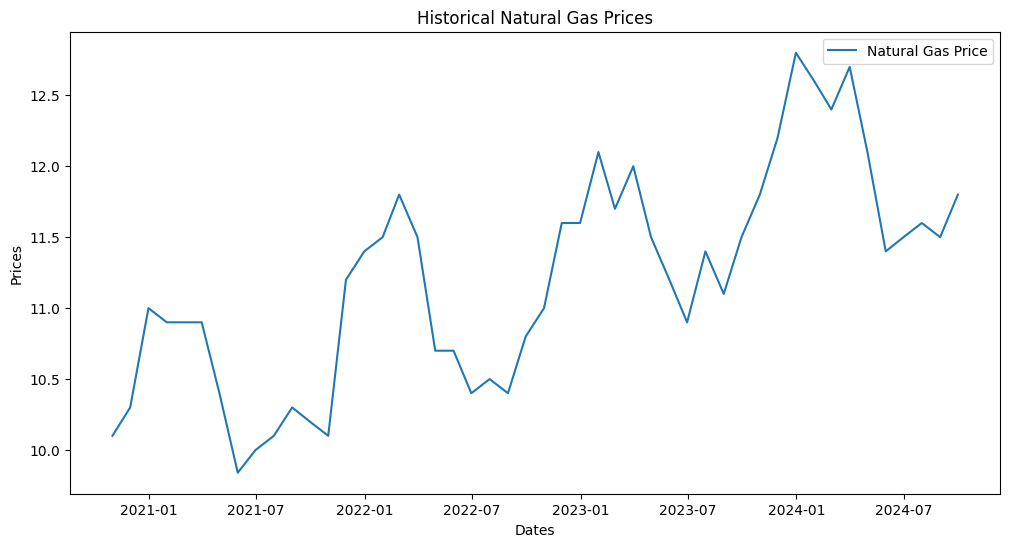

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_gas.index, df_gas['Prices'], label='Natural Gas Price')

plt.title('Historical Natural Gas Prices')

plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend()
plt.show()

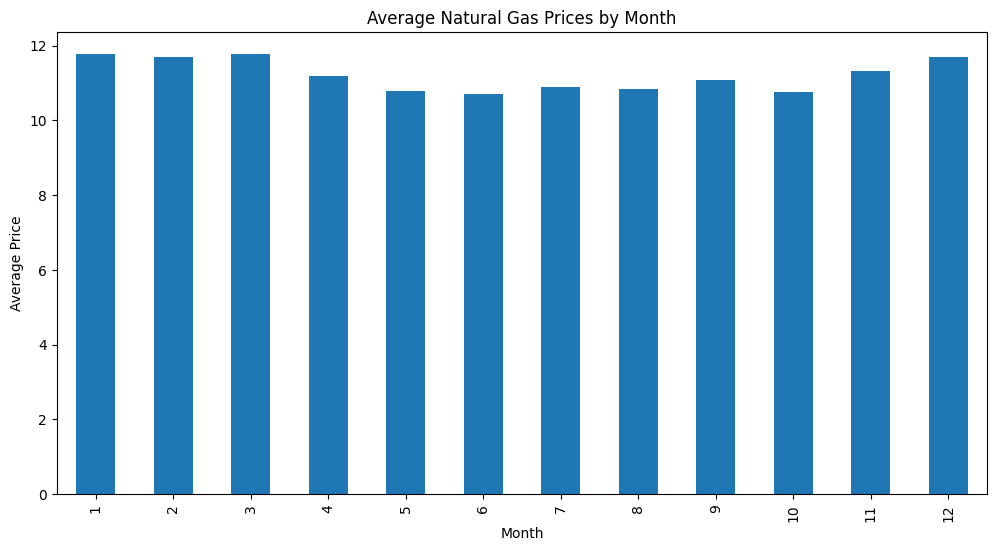

In [25]:
import matplotlib.pyplot as plt

df_gas['Month'] = df_gas.index.month

monthly_avg_prices = df_gas.groupby('Month')['Prices'].mean()

plt.figure(figsize=(12, 6))
monthly_avg_prices.plot(kind='bar')

plt.title('Average Natural Gas Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()

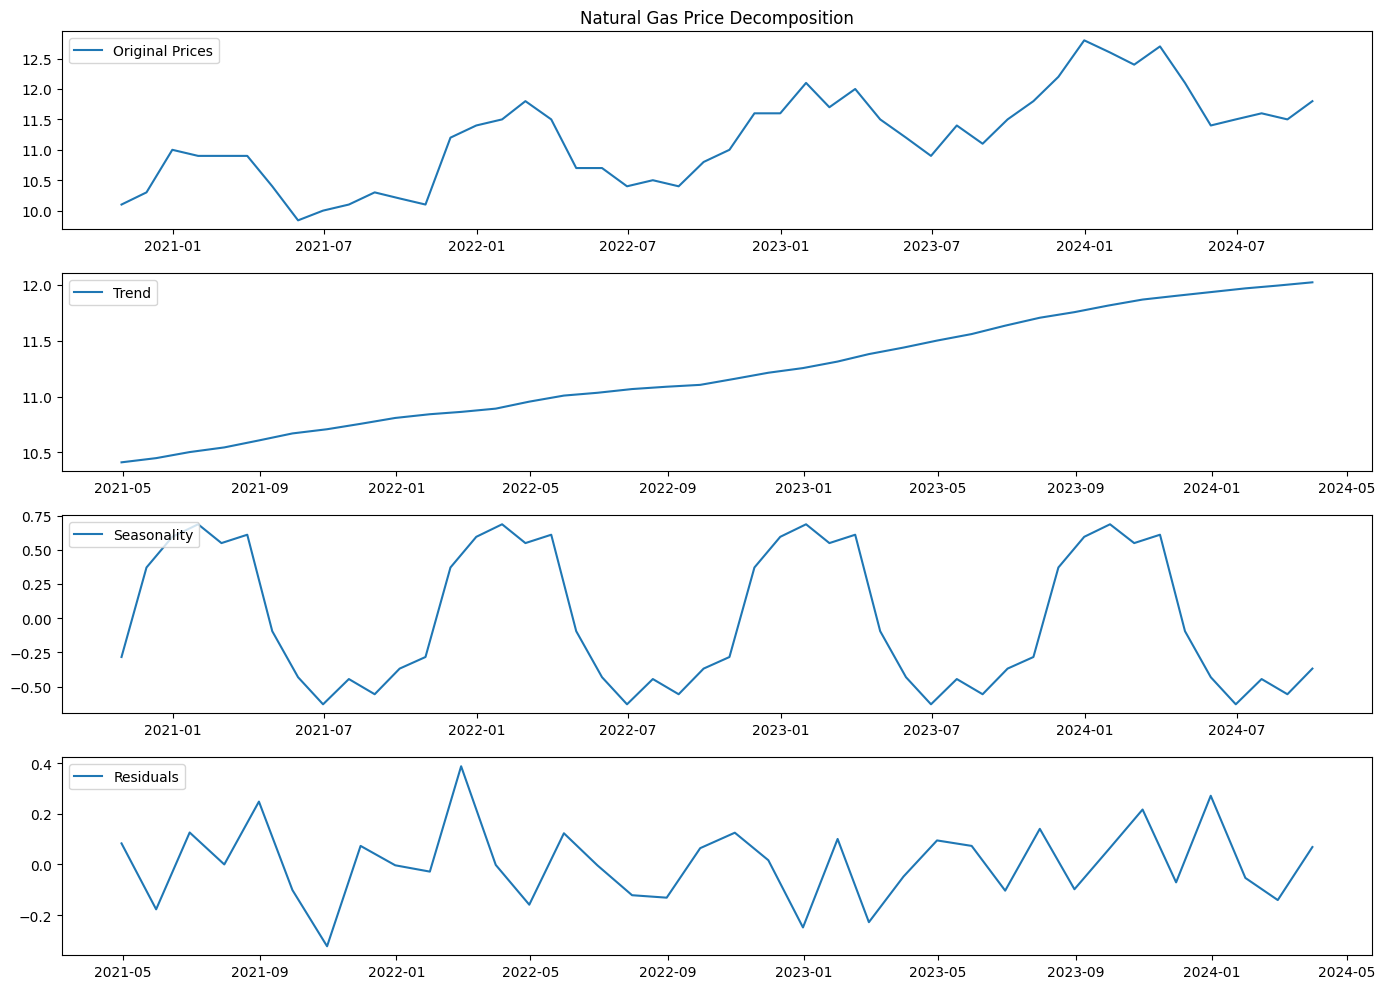

First few values of the Trend component:
Dates
2020-10-31   NaN
2020-11-30   NaN
2020-12-31   NaN
2021-01-31   NaN
2021-02-28   NaN
Name: trend, dtype: float64

First few values of the Seasonal component:
Dates
2020-10-31   -0.284051
2020-11-30    0.370671
2020-12-31    0.594838
2021-01-31    0.686505
2021-02-28    0.549005
Name: seasonal, dtype: float64

First few values of the Residual component:
Dates
2020-10-31   NaN
2020-11-30   NaN
2020-12-31   NaN
2021-01-31   NaN
2021-02-28   NaN
Name: resid, dtype: float64


In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_gas['Prices'], model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(df_gas['Prices'], label='Original Prices')
plt.legend(loc='upper left')
plt.title('Natural Gas Price Decomposition')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("First few values of the Trend component:")
print(trend.head())
print("\nFirst few values of the Seasonal component:")
print(seasonal.head())
print("\nFirst few values of the Residual component:")
print(residual.head())

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression

last_date = df_gas.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), end='2025-09-30', freq='MS')
future_df = pd.DataFrame(index=future_dates)

average_seasonal_components = seasonal.groupby(seasonal.index.month).mean()

trend_filtered = trend.dropna()
X_trend = trend_filtered.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y_trend = trend_filtered.values

trend_model = LinearRegression()
trend_model.fit(X_trend, y_trend)

X_future = future_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
future_trend = trend_model.predict(X_future)
future_df['Trend'] = future_trend

future_df['Prices'] = future_df['Trend'] + future_df.index.month.map(average_seasonal_components)

extrapolated_df = pd.concat([df_gas, future_df[['Prices']]])

print("Extrapolated prices DataFrame head:")
print(extrapolated_df.tail())
print("\nExtrapolated prices DataFrame info:")
extrapolated_df.info()

Extrapolated prices DataFrame head:
               Prices  Month
2025-05-01  12.215251    NaN
2025-06-01  12.065028    NaN
2025-07-01  12.296039    NaN
2025-08-01  12.232760    NaN
2025-09-01  12.468092    NaN

Extrapolated prices DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-10-31 to 2025-09-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  59 non-null     float64
 1   Month   48 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


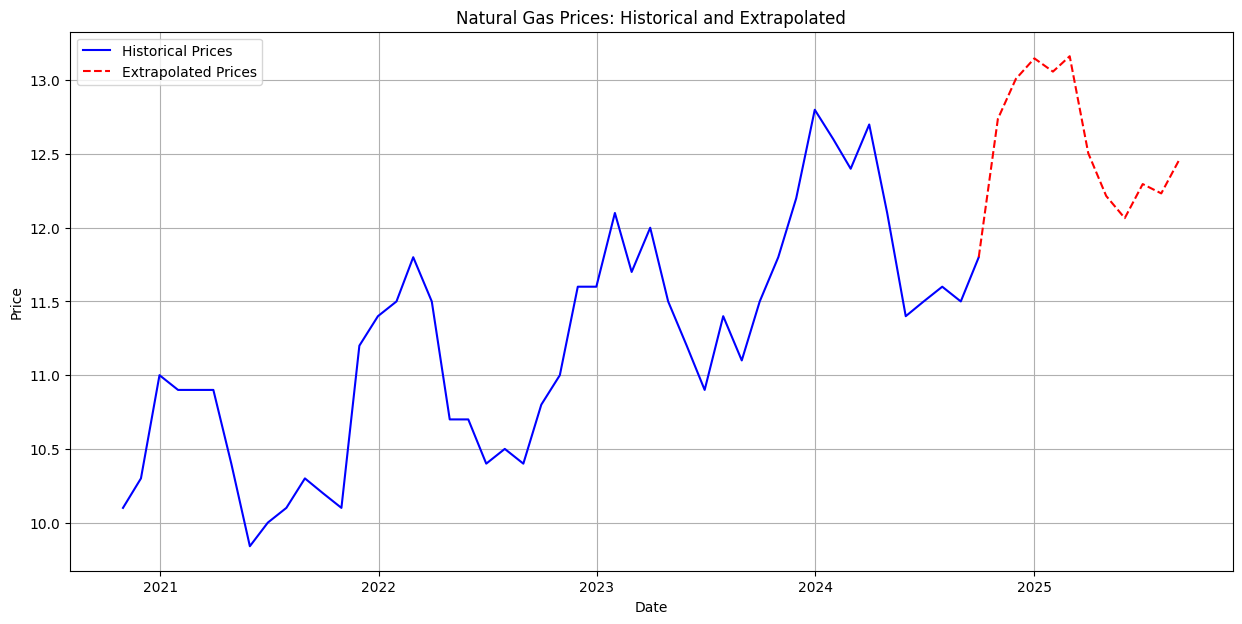

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(df_gas.index, df_gas['Prices'], label='Historical Prices', color='blue')

plt.plot(extrapolated_df.loc[df_gas.index.max():].index, extrapolated_df.loc[df_gas.index.max():]['Prices'], label='Extrapolated Prices', color='red', linestyle='--')

plt.title('Natural Gas Prices: Historical and Extrapolated')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()

plt.grid(True)

plt.show()

In [29]:
import pandas as pd

daily_date_range = pd.date_range(start=extrapolated_df.index.min(), end=extrapolated_df.index.max(), freq='D')

daily_extrapolated_prices = extrapolated_df['Prices'].reindex(daily_date_range)

daily_extrapolated_prices = daily_extrapolated_prices.interpolate(method='linear')

print("First few rows of daily_extrapolated_prices:")
print(daily_extrapolated_prices.head())
print("\nLast few rows of daily_extrapolated_prices:")
print(daily_extrapolated_prices.tail())
print("\nInformation about daily_extrapolated_prices:")
daily_extrapolated_prices.info()

First few rows of daily_extrapolated_prices:
2020-10-31    10.100000
2020-11-01    10.106667
2020-11-02    10.113333
2020-11-03    10.120000
2020-11-04    10.126667
Freq: D, Name: Prices, dtype: float64

Last few rows of daily_extrapolated_prices:
2025-08-28    12.437726
2025-08-29    12.445318
2025-08-30    12.452909
2025-08-31    12.460500
2025-09-01    12.468092
Freq: D, Name: Prices, dtype: float64

Information about daily_extrapolated_prices:
<class 'pandas.core.series.Series'>
DatetimeIndex: 1767 entries, 2020-10-31 to 2025-09-01
Freq: D
Series name: Prices
Non-Null Count  Dtype  
--------------  -----  
1767 non-null   float64
dtypes: float64(1)
memory usage: 27.6 KB


In [30]:
def estimate_gas_price(date_input):
    try:
        target_date = pd.to_datetime(date_input)
    except Exception:
        return "Invalid date format. Please provide a valid date."

    if target_date in daily_extrapolated_prices.index:
        return daily_extrapolated_prices.loc[target_date]
    else:
        min_date = daily_extrapolated_prices.index.min().strftime('%Y-%m-%d')
        max_date = daily_extrapolated_prices.index.max().strftime('%Y-%m-%d')
        return f"Date {target_date.strftime('%Y-%m-%d')} is outside the available estimation range ({min_date} to {max_date})."

print("\nDemonstrating price estimation function:")

historical_date = '2021-06-15'
price_historical = estimate_gas_price(historical_date)
print(f"Estimated price for {historical_date}: {price_historical:.2f}" if isinstance(price_historical, float) else f"Estimated price for {historical_date}: {price_historical}")

extrapolated_date = '2025-03-20'
price_extrapolated = estimate_gas_price(extrapolated_date)
print(f"Estimated price for {extrapolated_date}: {price_extrapolated:.2f}" if isinstance(price_extrapolated, float) else f"Estimated price for {extrapolated_date}: {price_extrapolated}")

out_of_range_before = '2020-01-01'
price_out_before = estimate_gas_price(out_of_range_before)
print(f"Estimated price for {out_of_range_before}: {price_out_before}")

out_of_range_after = '2026-01-15'
price_out_after = estimate_gas_price(out_of_range_after)
print(f"Estimated price for {out_of_range_after}: {price_out_after}")

start_date = daily_extrapolated_prices.index.min().strftime('%Y-%m-%d')
price_start = estimate_gas_price(start_date)
print(f"Estimated price for {start_date} (start of range): {price_start:.2f}" if isinstance(price_start, float) else f"Estimated price for {start_date} (start of range): {price_start}")

end_date = daily_extrapolated_prices.index.max().strftime('%Y-%m-%d')
price_end = estimate_gas_price(end_date)
print(f"Estimated price for {end_date} (end of range): {price_end:.2f}" if isinstance(price_end, float) else f"Estimated price for {end_date} (end of range): {price_end}")


Demonstrating price estimation function:
Estimated price for 2021-06-15: 9.92
Estimated price for 2025-03-20: 12.76
Estimated price for 2020-01-01: Date 2020-01-01 is outside the available estimation range (2020-10-31 to 2025-09-01).
Estimated price for 2026-01-15: Date 2026-01-15 is outside the available estimation range (2020-10-31 to 2025-09-01).
Estimated price for 2020-10-31 (start of range): 10.10
Estimated price for 2025-09-01 (end of range): 12.47


In [31]:
import pandas as pd
from datetime import timedelta

def price_gas_contract(
    injection_events: list[dict],
    withdrawal_events: list[dict],
    max_storage_volume: float,
    storage_cost_per_unit_per_day: float
) -> float:

    total_cash_flow = 0.0
    current_storage_volume = 0.0
    total_storage_cost = 0.0

    # Collect all relevant events and sort them by date
    all_events = []
    for event in injection_events:
        event_date = pd.to_datetime(event['date'])
        price = estimate_gas_price(event_date)
        if isinstance(price, str):
            return f"Error: Injection date {event['date']} is out of range: {price}"
        all_events.append({'date': event_date, 'type': 'injection', 'volume': event['volume'], 'price': price})

    for event in withdrawal_events:
        event_date = pd.to_datetime(event['date'])
        price = estimate_gas_price(event_date)
        if isinstance(price, str):
            return f"Error: Withdrawal date {event['date']} is out of range: {price}"
        all_events.append({'date': event_date, 'type': 'withdrawal', 'volume': event['volume'], 'price': price})

    if not all_events:
        return 0.0  # No events, no contract value

    all_events.sort(key=lambda x: x['date'])

    first_event_date = all_events[0]['date']
    last_event_date = all_events[-1]['date']

    # Simulate day by day to calculate cash flows and storage costs
    current_day = first_event_date
    while current_day <= last_event_date:
        # Process all events occurring on the current day
        daily_transactions = [e for e in all_events if e['date'] == current_day]

        for event in daily_transactions:
            if event['type'] == 'injection':
                # Cost of purchasing gas
                total_cash_flow -= event['volume'] * event['price']
                current_storage_volume += event['volume']
                # Enforce maximum storage volume (excess is assumed to be lost for simplicity)
                if current_storage_volume > max_storage_volume:
                    current_storage_volume = max_storage_volume
            elif event['type'] == 'withdrawal':
                # Revenue from selling gas
                total_cash_flow += event['volume'] * event['price']
                current_storage_volume -= event['volume']
                # Enforce minimum storage volume (shortage is assumed to be covered at no additional cost for simplicity)
                if current_storage_volume < 0:
                    current_storage_volume = 0

        # Calculate storage cost for the gas held at the end of the day
        if current_storage_volume > 0:
            total_storage_cost += current_storage_volume * storage_cost_per_unit_per_day

        current_day += timedelta(days=1)

    # Subtract total storage costs from the total cash flow
    final_contract_value = total_cash_flow - total_storage_cost

    return final_contract_value

In [32]:

# Test Cases for the pricing model
print("\n--- Testing the Gas Contract Pricing Model ---\n")

# Test Case 1: Simple inject and withdraw within historical range
injection_1 = [{'date': '2021-01-15', 'volume': 1000.0}]
withdrawal_1 = [{'date': '2021-07-15', 'volume': 1000.0}]
max_storage_1 = 2000.0
storage_cost_1 = 0.005 # $0.005 per unit per day

value_1 = price_gas_contract(injection_1, withdrawal_1, max_storage_1, storage_cost_1)
print(f"Test Case 1 (Simple Historical): {value_1:.2f}")

# Test Case 2: Inject and withdraw with profit (using extrapolated data)
injection_2 = [{'date': '2024-12-01', 'volume': 5000.0}]
withdrawal_2 = [{'date': '2025-03-01', 'volume': 5000.0}]
max_storage_2 = 10000.0
storage_cost_2 = 0.003

value_2 = price_gas_contract(injection_2, withdrawal_2, max_storage_2, storage_cost_2)
print(f"Test Case 2 (Extrapolated Profit): {value_2:.2f}")

# Test Case 3: Multiple injections and withdrawals with storage limits and higher costs
injection_3 = [
    {'date': '2023-05-01', 'volume': 3000.0},
    {'date': '2023-06-01', 'volume': 4000.0}
]
withdrawal_3 = [
    {'date': '2023-10-01', 'volume': 2000.0},
    {'date': '2023-11-01', 'volume': 5000.0} # This will cause a temporary shortage if not handled
]
max_storage_3 = 6000.0 # Max capacity
storage_cost_3 = 0.01

value_3 = price_gas_contract(injection_3, withdrawal_3, max_storage_3, storage_cost_3)
print(f"Test Case 3 (Multiple events, limits): {value_3:.2f}")

# Test Case 4: Date out of range (should return an error message)
injection_4 = [{'date': '2026-01-01', 'volume': 100.0}]
withdrawal_4 = [{'date': '2026-02-01', 'volume': 100.0}]
max_storage_4 = 500.0
storage_cost_4 = 0.001

value_4 = price_gas_contract(injection_4, withdrawal_4, max_storage_4, storage_cost_4)
print(f"Test Case 4 (Date out of range): {value_4}")

# Test Case 5: Empty events lists
value_5 = price_gas_contract([], [], 1000.0, 0.001)
print(f"Test Case 5 (Empty events): {value_5:.2f}")



--- Testing the Gas Contract Pricing Model ---

Test Case 1 (Simple Historical): -1808.23
Test Case 2 (Extrapolated Profit): -579.28
Test Case 3 (Multiple events, limits): -6634.95
Test Case 4 (Date out of range): Error: Injection date 2026-01-01 is out of range: Date 2026-01-01 is outside the available estimation range (2020-10-31 to 2025-09-01).
Test Case 5 (Empty events): 0.00
